In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [15]:
%matplotlib inline 
%env CUDA_VISIBLE_DEVICES=7
%env BLISS_HOME=/home/yppatel/bliss

env: CUDA_VISIBLE_DEVICES=7
env: BLISS_HOME=/home/yppatel/bliss


In [3]:
import matplotlib.pyplot as plt
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.strong_lensing.plots.main import load_models

from astropy.io import fits
from astropy.table import Table

In [4]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

7


# Load data

In [5]:
# load sdss data
sdss_dir = '/home/yppatel/bliss/data/sdss/'
pixel_scale = 0.393
coadd_file = "/home/yppatel/bliss/data/sdss/coadd_catalog_94_1_12.fits"
frame = SDSSFrame(sdss_dir, pixel_scale, coadd_file)

In [6]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="config"):
    cfg = compose("config", overrides=[])
    
    
enc, dec = load_models(cfg, device)
bp = enc.border_padding
torch.cuda.empty_cache()

In [7]:
# get catalog 
h, w = bp, bp
h_end = ((frame.image.shape[2] - 2 * bp) // 4) * 4 + bp #adjustments when using whole frame.
w_end = ((frame.image.shape[3] - 2 * bp) // 4) * 4 + bp
coadd_params = frame.get_catalog((h, h_end), (w, w_end))

In [8]:
# frame PHOTO catalog
frame_cat = Table.read('../../data/sdss/5313/3/117/photoObj-005313-3-0117.fits')

In [9]:
print("# objects detected by photo on frame: ", len(frame_cat))
print("# objects detected by photo on coadd: ", coadd_params.n_sources.sum().item())

# objects detected by photo on frame:  1478
# objects detected by photo on coadd:  889


In [10]:
f = fits.open('../../data/sdss/5313/3/117/frame-r-005313-3-0117.fits')[0].data

# Get Locations

In [11]:
#inference
import numpy as np
img_cp = torch.from_numpy(np.log(np.log(f - f.min() + 2) + 1) * 1600).unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    _, tile_est = reconstruct_scene_at_coordinates(
        enc,
        dec,
        img_cp,
        frame.background,
        h_range=(h, h_end),
        w_range=(w, w_end),
    )
map_recon = tile_est.to_full_params()
torch.cuda.empty_cache()

Encoding ptiles: 24it [00:25,  1.07s/it]


In [12]:
# prepare inference locs
import numpy as np
plocs = map_recon.plocs.cpu().numpy().squeeze() + bp - 0.5 # plotting adjustment
coords = frame.wcs.all_pix2world(np.hstack([plocs[:, 1, None], plocs[:, 0, None]]), 0)
galaxy_bool = map_recon['galaxy_bools'].cpu().numpy().astype(bool).squeeze()
galaxy_prob = map_recon['galaxy_probs'].cpu().numpy().squeeze()


In [13]:
# coadd params
coplocs = coadd_params.plocs.squeeze().numpy() + bp - 0.5 # plotting adjustment
cogbool = coadd_params['galaxy_bools'].squeeze().numpy()

cora = coadd_params['ra'].squeeze().numpy()
codec = coadd_params['dec'].squeeze().numpy()
comags = coadd_params['mags'].squeeze().numpy()

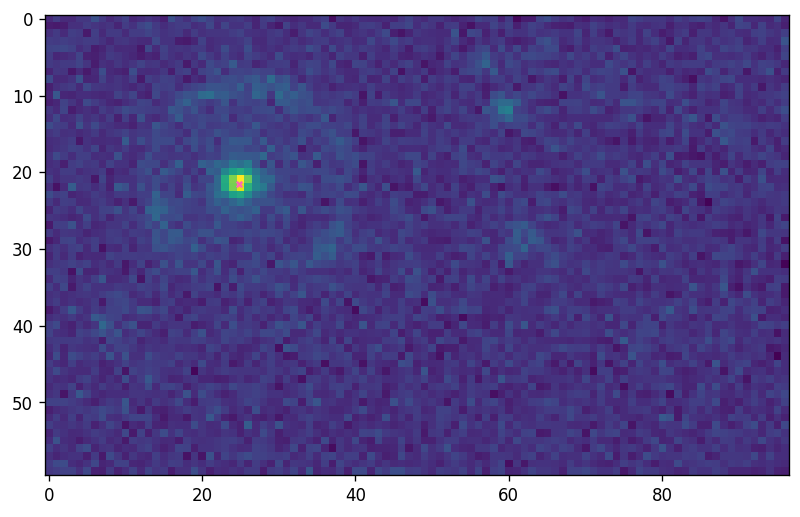

In [16]:
cogbool = cogbool.astype("bool")
image = frame.image.squeeze().numpy()

lensed_galaxy_bools = map_recon['lensed_galaxy_bools'].cpu().numpy().astype(bool).squeeze()

plt.rcParams["axes.grid"] = False
fig, axs = plt.subplots(1, 1, figsize=(8, 6), dpi=120)
fig = plt.imshow(img_cp[0,0,1003:1063, 903:1000])

lensed_locs = plocs[lensed_galaxy_bools]
masked_locs = lensed_locs[
    np.logical_and(
    np.logical_and(
        1003 <= lensed_locs[:, 0], lensed_locs[:, 0] <= 1063,
    ),
    np.logical_and(
        903 <= lensed_locs[:, 1], lensed_locs[:, 1] <= 1000,
    ),
    )
].copy()

masked_locs[:, 0] -= 1003
masked_locs[:, 1] -= 903

# lensed_probs = map_recon['lensed_galaxy_probs'].squeeze()[lensed_galaxy_bools][
#     np.logical_and(
#     np.logical_and(
#         1003 <= lensed_locs[:, 0], lensed_locs[:, 0] <= 1063,
#     ),
#     np.logical_and(
#         903 <= lensed_locs[:, 1], lensed_locs[:, 1] <= 1000,
#     ),
#     )
# ]

# print(lensed_probs)

# create scatter objects
# axs.scatter(label='galaxy coadd', x=coplocs[cogbool][:, 1], y=coplocs[cogbool][:, 0], 
#                                      color='red', s=11, marker='+')
axs.scatter(label='galaxy pred', x=masked_locs[:, 1], y=masked_locs[:, 0], 
                                     color='hotpink', s=11, marker='x')

In [150]:
plocs.shape

(134, 2)

In [151]:
np.mean(map_recon['lensed_galaxy_probs'][0,...].cpu().numpy())

0.0308633

In [153]:
dataset = instantiate(
    cfg.datasets.simulated,
    generate_device="cuda:0",
)

sample_batch_size = 16
tile_catalog = dataset.sample_prior(sample_batch_size, cfg.datasets.simulated.n_tiles_h, cfg.datasets.simulated.n_tiles_w)
tile_catalog.set_all_fluxes_and_mags(dataset.image_decoder)
images, backgrounds = dataset.simulate_image_from_catalog(tile_catalog)

In [ ]:
tile_map = enc.variational_mode(images, backgrounds)
full_map = tile_map.cpu().to_full_params()
full_true = tile_catalog.cpu().to_full_params()

plt.rcParams["axes.grid"] = False
# fig, axs = plt.subplots(1, 1, figsize=(8, 6), dpi=120)

# test_i = 9
# fig = plt.imshow(images[test_i,0,:,:].cpu())
# true_lens_pos = full_true.plocs[test_i,...][torch.nonzero(full_true["lensed_galaxy_bools"][test_i,:,0])].squeeze(1)
# print(full_true["lens_params"][test_i,2,:])
# plt.scatter(true_lens_pos[:, 1] - 0.5 + enc.border_padding, true_lens_pos[:, 0] - 0.5 + enc.border_padding, marker='x', 
#             color='r', s=75)

fig, axs = plt.subplots(sample_batch_size // 4, 4, figsize=(8, 6), dpi=120)

# print([torch.sum(full_true["galaxy_bools"][i,...]) for i in range(16)])
# print([torch.sum(full_map["galaxy_bools"][i,...]) for i in range(16)])

for i in range(sample_batch_size):
    if i != 13:
        continue
    offset_i = i# + 64

    # axs[i // 4, i % 4].imshow(images[offset_i,0,:,:].cpu() + image[1003:1091, 903:991])

    true_lens_pos = full_true.plocs[i,...][torch.nonzero(full_true["galaxy_bools"][i,:,0])].squeeze(1)
    map_lens_pos = full_map.plocs[i,...][torch.nonzero(full_map["galaxy_bools"][i,:,0])].squeeze(1)

    true_lens_pos = full_true.plocs[offset_i,...][torch.nonzero(full_true["lensed_galaxy_bools"][offset_i,:,0])].squeeze(1)
    map_lens_pos = full_map.plocs[offset_i,...][torch.nonzero(full_map["lensed_galaxy_bools"][offset_i,:,0])].squeeze(1)

#     axs[i // 4, i % 4].scatter(true_lens_pos[:, 1] - 0.5 + enc.border_padding, true_lens_pos[:, 0] - 0.5 + enc.border_padding, marker='x', 
#             color='r', s=75)
#     axs[i // 4, i % 4].scatter(map_lens_pos[:, 1] - 0.5 + enc.border_padding, map_lens_pos[:, 0] - 0.5 + enc.border_padding, marker='+', 
#                 color='b', s=100)

In [ ]:
img_cp = frame.image.clone().to("cuda:0")
# img_cp[0,0,1003:1091,903:991] = (img_cp[0,0,1003:1091,903:991] + images[offset_i,0,:,:]) / 2

# print(f[1003:1091, 903:991] / f[1003:1091, 903:991].sum())
# print(img_cp[1003:1091, 903:991] / img_cp[1003:1091, 903:991].sum())
# plt.imshow(np.log(np.log(img_cp - img_cp.min() + 2) + 1)[1003:1091, 903:991])
# plt.imshow(f[1003:1091, 903:991])
plt.imshow(img_cp.cpu().numpy()[0,0,1003:1091, 903:991]) 

In [ ]:
print(img_cp[1003:1091, 903:991].shape)
print(images[offset_i,0,:,:].cpu().numpy().shape)

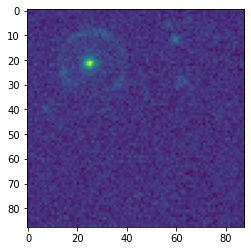

In [36]:
plt.imshow(()[1003:1091, 903:991])